# 前回からの課題
- 複数回繰り返す前処理は関数化して管理しやすくする
- state=live, suspendedを除去
- 多数決は >=3 にする

# 方針
- フィルター法とラッパー法と埋め込み法を試す
- 決定木、ランダムフォレスト、アダブーストを試す
- 決定木＋SGDClassifier＋SVCのアンサンブル学習を試す
- 多層パーセプトロンを試す(tf.keras, pytorch, sklearn)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import summarize_to_others

In [2]:
# sklearn Model
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
# Data process
from sklearn.model_selection import KFold, train_test_split
# Metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [17]:
# データの読み込み
df = pd.read_csv('./data/ks-projects-201801.csv')
print(df.shape)
df.head()

(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


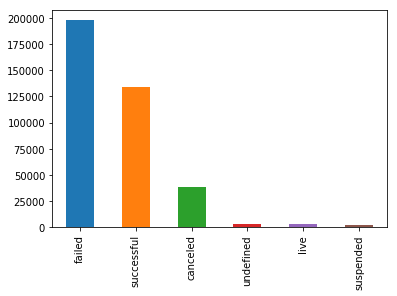

In [18]:
# 目的変数の可視化
display(df.state.value_counts().plot.bar())

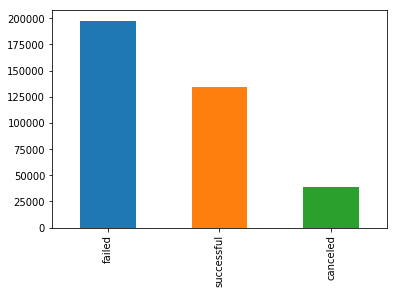

In [23]:
# 目的変数の条件を指定する
df['state'] = df['state'].apply(lambda x: x if x not in set(['live', 'undefined', 'suspended']) else None)
df['state'].value_counts().plot.bar()

In [24]:
# データフレーム全体に反映させる
dropped_df = df.dropna()
display(df.shape)
display(dropped_df.shape)

(378661, 15)

(370219, 15)

In [25]:
# ID のドロップ
dropped_df = dropped_df.drop('ID', axis=1)
display(dropped_df.shape)
dropped_df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


0    False
1    False
2    False
3    False
4    False
Name: state, dtype: bool

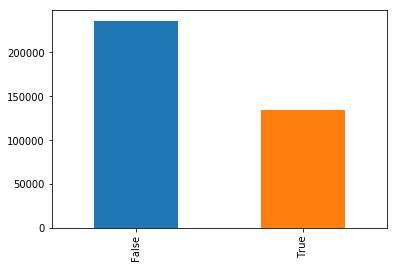

In [26]:
# successful or failed の二値化
y_bool = dropped_df['state'] == 'successful'
display(y_bool.head())
y_bool.value_counts().plot.bar()

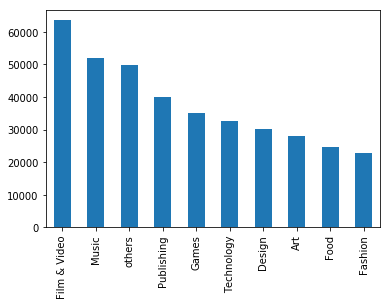

In [7]:
new_df = summarize_to_others(df, 'main_category', 15000)
new_df.value_counts().plot.bar()